## dataset path setting

In [1]:
from google.colab import drive

# mount googledrive to notebook
drive.mount('/content/gdrive')
# Justice data path
justice_path = '/content/gdrive/Shareddrives/VaiL_Services/Research/Little_AI_Scholars/Groups_2023/JJP_group/proj_container/Phoebe_auto_judgement/dataset/'

Mounted at /content/gdrive


## import libraries

In [42]:
# imports
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

## read data

In [43]:
df = pd.read_pickle(os.path.join(justice_path,'justice_data.pkl'))
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

print(f'There are {len(df)} cases.')

There are 3464 cases.


## download nltk data

In [44]:
# down load nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# setting stopword
stop = stopwords.words('english')
stop.remove('no')
stop.remove('not')

# setting lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## data clean

In [45]:
def data_clean(fact):
    """This is to clean the facts. Will remove the first party and second party name

    Args:
        first_party:    first party name
        second_party:   second party name
        fact:           fact text

    return:
        cleaned fact"""
    # 1. lower-case for the text, also remove some punctuations

    fact_text = fact.lower().replace(',', '')
    fact_text = fact_text.replace('<p>', '')
    fact_text = fact_text.replace('</p>\n', '')
    # print(fact_text)

    # 2. replace/remove the name of the first party and second party

    #fact_split = ' '.join([x for x in fact_text.split(' ') if x not in first_second_party])

    # 3. remove punctuations and numbers
    fact_clean = re.sub('[^a-zA-Z]', ' ', fact_text)

    # 4. remove single character
    fact_clean = re.sub(r"\s+[a-zA-Z]\s+", ' ', fact_clean)

    # 5. remove multiple spaces
    fact_clean = re.sub(r'\s+', ' ', fact_clean)

    # 6. token
    fact_clean = word_tokenize(fact_clean)

    # 7. remove stop words
    fact_clean = [word for word in fact_clean if word not in (stop)]

    # 8. lemmatizer
    fact_clean = [lemmatizer.lemmatize(word) for word in fact_clean]

    # join token to text
    fact_clean = ' '.join(fact_clean)


    return fact_clean

In [46]:
df['cleaned facts'] = df.apply(lambda x: data_clean(x.facts), axis=1)

## TF-IDF vectorization and category labelling

In [47]:
# TF-IDF
vectorizer_facts = TfidfVectorizer()
vectorizer_clean_facts = vectorizer_facts.fit_transform(df['cleaned facts'])
facts_clean_array = vectorizer_clean_facts.toarray()

In [48]:
# cateogry labelling
label_encoder = preprocessing.LabelEncoder()
data_label = label_encoder.fit_transform(df['winner_index'])

## Data augmentation and balancing

In [49]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
facts_clean_array_re,data_label_re=smote.fit_resample(facts_clean_array,data_label)

## Data split for train and test

In [50]:
X_train, X_test, y_train, y_test = train_test_split(facts_clean_array_re, data_label_re, test_size=0.2,random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3382, 14713) (846, 14713) (3382,) (846,)


In [51]:
input_length = 200
word_nums = X_train.shape[1]//input_length
print(X_train[:, 0:input_length*word_nums].shape)
X_train_reshape = X_train[:,0:input_length*word_nums].reshape((-1,input_length,word_nums))
X_test_reshape = X_test[:,0:input_length*word_nums].reshape((-1,input_length,word_nums))
print(X_train_reshape.shape, X_test_reshape.shape)

(3382, 14600)
(3382, 200, 73) (846, 200, 73)


## build model

In [52]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(256,5, activation='relu', input_shape=(input_length, word_nums)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Conv1D(128,3,activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Conv1D(64,5,activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=1,
                                       padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## model training

In [53]:
history=model.fit(X_train_reshape, y_train, epochs=20, validation_data=(X_test_reshape, y_test), batch_size=128)

Epoch 1/20
27/27 [==============================] - 27s 946ms/step - loss: 0.6890 - accuracy: 0.5334 - val_loss: 0.6681 - val_accuracy: 0.6395
Epoch 2/20
27/27 [==============================] - 26s 986ms/step - loss: 0.6269 - accuracy: 0.6632 - val_loss: 0.5946 - val_accuracy: 0.6430
Epoch 3/20
27/27 [==============================] - 27s 1s/step - loss: 0.4575 - accuracy: 0.8054 - val_loss: 0.4102 - val_accuracy: 0.8274
Epoch 4/20
27/27 [==============================] - 27s 990ms/step - loss: 0.2776 - accuracy: 0.9015 - val_loss: 0.2905 - val_accuracy: 0.9090
Epoch 5/20
27/27 [==============================] - 28s 1s/step - loss: 0.1478 - accuracy: 0.9568 - val_loss: 0.2682 - val_accuracy: 0.8948
Epoch 6/20
27/27 [==============================] - 26s 963ms/step - loss: 0.0731 - accuracy: 0.9831 - val_loss: 0.1411 - val_accuracy: 0.9622
Epoch 7/20
27/27 [==============================] - 25s 926ms/step - loss: 0.0291 - accuracy: 0.9944 - val_loss: 0.1712 - val_accuracy: 0.9409
Epoch

## model testing

In [54]:
classifications= model.predict(X_test_reshape)
pred_test = classifications.argmax(axis=1)
accuracy_score(y_true=y_test, y_pred=pred_test)

27/27 [==============================] - 3s 98ms/step


0.950354609929078

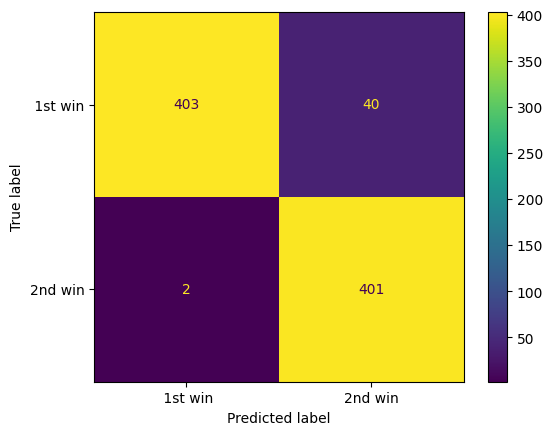

In [55]:

Con_matrix=confusion_matrix(y_test, pred_test)
classes =[" 1st win","2nd win"]
disp = ConfusionMatrixDisplay(confusion_matrix=Con_matrix, display_labels=classes)
disp.plot(
    include_values=True,
    cmap='viridis',
    ax=None,
    xticks_rotation='horizontal',
    values_format='d'
)
plt.show()

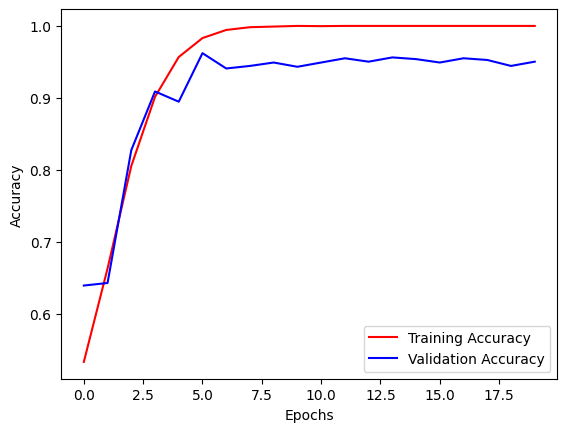

In [56]:
train_acc_history = history.history['accuracy']
test_acc_history = history.history['val_accuracy']
plt.plot(train_acc_history,c='r')
plt.plot(test_acc_history,c='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()